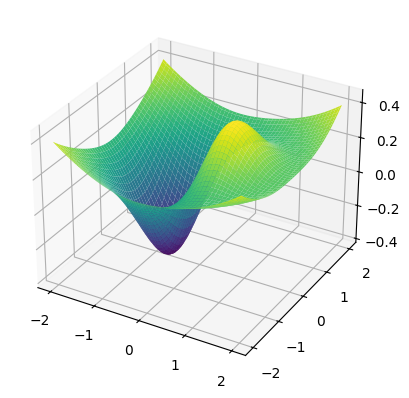

In [7]:
import time
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import os
import pandas as pd
import yfinance as yf


def target_functin(x, y):
    return x * np.exp(-x**2 - y**2) + (x**2 + y**2) / 20


def plot_target_function():
    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    Z = target_functin(X, Y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    plt.show()

plot_target_function()

## Minimizing the function using grid search

In [2]:
def target_functin_2(x, y, z):
    return x * np.exp(-x**2 - y**2 - z**2) + (x**2 + y**2 + z**2) / 20

# array of x values from -10 to 10 with 1000 points
x = np.linspace(-10, 10, 200)

# array of y values from -10 to 10 with 1000 points
y = np.linspace(-10, 10, 200)

# array of z values from -10 to 10 with 1000 points
z = np.linspace(-10, 10, 200)


min_value = np.inf
x_of_min = 0
y_of_min = 0
z_of_min = 0

start = time.time()
for i in x:
    for j in y:
        for k in z:
            value = target_functin_2(i, j, k)
            if value < min_value:
                min_value = value
                x_of_min = i
                y_of_min = j
                z_of_min = k

print("Time: ", time.time() - start)
print("Min value: ", min_value)
print("x of min: ", x_of_min)
print("y of min: ", y_of_min)
print("z of min: ", z_of_min)


Time:  8.300153255462646
Min value:  -0.40259800683189245
x of min:  -0.6532663316582905
y of min:  -0.05025125628140614
z of min:  -0.05025125628140614


## Minimizing the function using random search

In [3]:
x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
z = np.linspace(-10, 10, 200)

min_value = np.inf
x_of_min = 0
y_of_min = 0
z_of_min = 0

start = time.time()

for i in x:
    for j in y:
        for k in z:
            if np.random.rand() > 0.1:
                continue

            value = target_functin_2(i, j, k)
            if value < min_value:
                min_value = value
                x_of_min = i
                y_of_min = j
                z_of_min = k

print("Time: ", time.time() - start)
print("Min value: ", min_value)
print("x of min: ", x_of_min)
print("y of min: ", y_of_min)
print("z of min: ", z_of_min)


Time:  2.6103413105010986
Min value:  -0.3931046616190809
x of min:  -0.6532663316582905
y of min:  -0.1507537688442202
z of min:  -0.05025125628140614


## Minimizing the function using Genetic algorithm

In [4]:
# Minimum value of the function using Genetic algorithm
n_population = 100
n_generation = 100
n_parents = 50
n_elite = 5

population = np.random.uniform(-10, 10, (n_population, 3))

min_value = np.inf
x_of_min = 0
y_of_min = 0
z_of_min = 0

start = time.time()

for _ in range(n_generation):

    # Calculate the value of the function for each individual in the population
    values = target_functin_2(population[:, 0], population[:, 1], population[:, 2])

    # Find the indices of the individuals that have the smallest values
    idx = np.argsort(values)
    if values[idx[0]] < min_value:
        min_value = values[idx[0]]
        x_of_min = population[idx[0], 0]
        y_of_min = population[idx[0], 1]
        z_of_min = population[idx[0], 2]

    # Select the best individuals in the current generation to be the parents of the next generation
    parents = population[idx[:n_parents]]

    # Create the next generation
    children = parents[np.random.choice(n_parents, n_population - n_elite, replace=True)]
    mutation = 0.1 * np.random.randn(n_population - n_elite, 3)
    children += mutation
    new_population = np.vstack([parents[:n_elite], children])

    population = new_population

print("Time: ", time.time() - start)
print("Min value: ", min_value)
print("x of min: ", x_of_min)
print("y of min: ", y_of_min)
print("z of min: ", z_of_min)

Time:  0.004823446273803711
Min value:  -0.4052246700611487
x of min:  -0.6682004572812267
y of min:  -5.340414416677157e-05
z of min:  -0.004902391628386581


# A real example based on the strategy that was proposed last session

In [22]:
def download_ticker(ticker):

    if not os.path.exists(os.path.join('Database', '_cache')):
        os.makedirs(os.path.join('Database', '_cache'))

    cache_dir = os.path.join('Database', '_cache', f"{ticker}-1d-5.csv")

    if os.path.exists(cache_dir):
        return

    data = yf.download(ticker, start="2016-01-01", end="2023-12-29")
    data.to_csv(cache_dir)

    return

# Load the data
def load_data(ticker):
    cache_dir = os.path.join('Database', '_cache', f"{ticker}-1d-5.csv")

    if not os.path.exists(cache_dir):
        download_ticker(ticker)

    data = pd.read_csv(cache_dir, index_col=0)
    data.index = pd.to_datetime(data.index, utc=True)
    data.index = data.index.tz_convert('US/Eastern')

    return data

def get_return_series(ticker_data):

    df = ticker_data.copy()
    df['daily_return'] = df['Close'].pct_change() * 100

    # # Calculate the historical volatility
    window = 22
    df['daily_changes'] = df['Close'] / df['Open'] - 1

    rolling_changes_std = df['daily_changes'].rolling(window=window).std()
    rolling_changes_std = rolling_changes_std.fillna(0)

    df['signal_return'] = 0.0

    # If daily_changes > 1 std, short the S&P
    short_mask = (df['daily_changes'] > rolling_changes_std).shift().fillna(False)
    df.loc[short_mask, 'signal_return'] = -1 * df.loc[short_mask, 'daily_return']

    # If daily_changes < -1 std, long the S&P
    long_mask = (df['daily_changes'] < -rolling_changes_std).shift().fillna(False)
    df.loc[long_mask, 'signal_return'] = df.loc[long_mask, 'daily_return']

    return_series = df['signal_return']

    return return_series


def get_sharpe_ratio(return_series):
    return return_series.mean() / return_series.std() * np.sqrt(252)

tickers = ['QQQ', 'TMF', 'VOO', 'SPY']

data_holder = {}
for ticker in tickers:
    ticker_data = load_data(ticker)
    data_holder[ticker] = ticker_data

# Calculate the Sharpe ratio for each ticker
sharpe_ratios = {}
return_series = {}
for ticker, ticker_data in data_holder.items():
    returns = get_return_series(ticker_data)
    return_series[ticker] = returns.dropna()
    sharpe_ratios[ticker] = get_sharpe_ratio(returns)


# Print the Sharpe ratios with 3 decimal points
for ticker, sharpe_ratio in sharpe_ratios.items():
    print(f"{ticker}: {sharpe_ratio:.3f}")

def get_portfolio_sharpe_ratio(weights, return_series):
    portfolio_return = return_series.dot(weights)
    return portfolio_return.mean() / portfolio_return.std() * np.sqrt(252)

QQQ: 0.718
TMF: 0.439
VOO: 0.597
SPY: 0.793


### The equal weight portfolio

In [23]:
# Equal weight portfolio
n_tickers = len(tickers)
weights = np.ones(n_tickers) / n_tickers

# Combine the return series to pandas DataFrame
return_series_df = pd.DataFrame(return_series)

portfolio_sharpe = get_portfolio_sharpe_ratio(weights, return_series_df)

print(f"Portfolio: {portfolio_sharpe:.3f}")

Portfolio: 0.838


### The Grid Search

In [29]:
import itertools

valid_combinations = []

# Generate all combinations of weights between 0 and 1
combinations = itertools.product([i / 100 for i in range(101)], repeat=4)

# Filter combinations with a sum of 1
for combo in combinations:
    if sum(combo) == 1:
        valid_combinations.append(combo)

best_sharpe = -np.inf
best_weights = None

start = time.time()
for weights in valid_combinations:
    portfolio_sharpe = get_portfolio_sharpe_ratio(weights, return_series_df)
    if portfolio_sharpe > best_sharpe:
        best_sharpe = portfolio_sharpe
        best_weights = weights

print("Time: ", time.time() - start)

print(f"Best Sharpe: {best_sharpe:.3f}")
print(f"Best weights: {best_weights}")

Time:  10.313452005386353
Best Sharpe: 0.903
Best weights: (0.24, 0.17, 0.0, 0.59)


### The random search

In [30]:
n_random_search = 10000

best_sharpe = -np.inf
best_weights = None

start = time.time()
for _ in range(n_random_search):

    weights = np.random.random(len(tickers))
    weights /= weights.sum()

    portfolio_sharpe = get_portfolio_sharpe_ratio(weights, return_series_df)

    if portfolio_sharpe > best_sharpe:
        best_sharpe = portfolio_sharpe
        best_weights = weights

print("Time: ", time.time() - start)

best_weights = [round(weight, 2) for weight in best_weights]

print(f"Best Sharpe: {best_sharpe:.3f}")
print(f"Best weights: {best_weights}")

Time:  0.6707313060760498
Best Sharpe: 0.900
Best weights: [0.31, 0.19, 0.0, 0.5]


### Using convex optimization

In [43]:
import cvxpy as cp
from pypfopt.efficient_frontier import EfficientFrontier

start = time.time()
covariance_matrix = return_series_df.cov()

# Define the number of strategies
num_strategies = len(returns)

ef = EfficientFrontier(returns, covariance_matrix)
weights = ef.max_sharpe(0)

expected_return, volatility, sharpe_ratio = ef.portfolio_performance(risk_free_rate=0)
sharpe_ratio *= 252 ** 0.5

print("Time: ", time.time() - start)

# Round the weights to 2 decimal points from the weights dictionary
weights = [round(weight, 2) for weight in weights.values()]

# Print the optimized portfolio performance
print("Portfolio Sharpe Ratio: {:.4f}".format(sharpe_ratio))
print ("weights: ", weights)

Time:  0.0086669921875
Portfolio Sharpe Ratio: 0.9028
weights:  [0.24, 0.17, 0.0, 0.59]
